# Harish Practise: ROC AUC Curve: Cost Benefit Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


# We are generating synthetic dataset using make_classification method

In [3]:
X, y = make_classification(
    n_features = 10,
    n_samples=1000,
    n_informative=4,
    n_redundant=6,
    n_repeated=0,
    n_classes=2,
    random_state=42
)   

# Spliting Data into Training and testing set

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

# Training a Logistic Regression Model

In [5]:
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       122
           1       0.69      0.66      0.68       128

    accuracy                           0.68       250
   macro avg       0.68      0.68      0.68       250
weighted avg       0.68      0.68      0.68       250



Let's assume above is the classification model for pneumonia detection. In this case, a recall of 0.66 for positive class is pretty bad because out of 100 psenumonia patients you are detecting the disease only in 66 and to remaining 34 patients you are saying you don't have a disease. We would like to increase this number even though it comes at the cost of increased false positives (i.e. telling a person that you have pneumonia, when in reality they don't).

Reduce the probability threshold to 0.4 (from a default of 0.5) to capture more cases of pneumonia

#### Change the thresold to see how precision, recall changes

In [7]:
probabilities = model.predict_proba(X_test)[:,1]
y_pred = (probabilities > 0.4).astype(int)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       122
           1       0.67      0.82      0.74       128

    accuracy                           0.70       250
   macro avg       0.71      0.70      0.69       250
weighted avg       0.71      0.70      0.70       250



As you can see here for class 1, the recall increased to 82% which is good but now we want 90% recall. We will find probability thresold associated with 90% recall using ROC curve.

# We will calculate False Positive Rate and True Positive Rate

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00819672, 0.00819672]),
 array([0.       , 0.0078125, 0.265625 , 0.265625 , 0.2890625]),
 array([       inf, 0.97928246, 0.80890214, 0.80840719, 0.80207033]))

In [12]:
desired_recall = 0.9

closest_index = np.argmin(abs(tpr - desired_recall))

tpr[closest_index], thresholds[closest_index], fpr[closest_index]
                        

(0.90625, 0.26349585272229664, 0.7049180327868853)

What this is saying is you need to configure your probability threshold to be 0.26 for a desired_recall value. Also you will have 0.7 false positive rate which is pretty high.

# Let see Area Under Curve

In [13]:
from sklearn.metrics import auc

area = auc(fpr,tpr)

area

0.764856557377049

# Plt ROC Curve

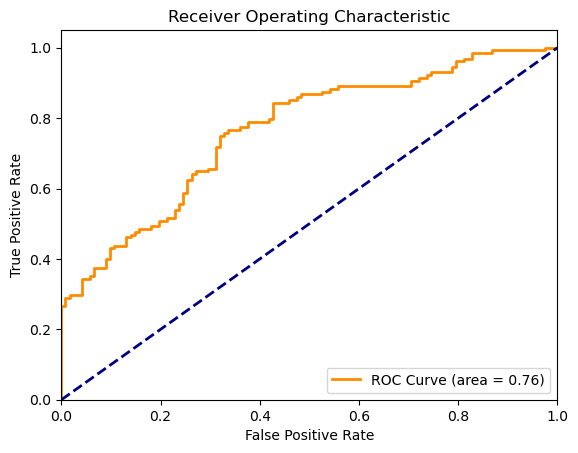

In [14]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Training XGBOOST MODEL

In [17]:
!pip install xgboost

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       122
           1       0.93      0.89      0.91       128

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



# Out of the box, it gives us 89% recall which is pretty good but now we became greedy and want 92% recall.

In [20]:
probabilities_xgb = model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, probabilities_xgb)

fpr_xgb[:5], tpr_xgb[:5],thresholds_xgb[:5]

(array([0.        , 0.        , 0.        , 0.00819672, 0.00819672]),
 array([0.       , 0.0078125, 0.09375  , 0.09375  , 0.203125 ]),
 array([       inf, 0.99996376, 0.99989676, 0.999892  , 0.9997204 ],
       dtype=float32))

In [21]:
area2 = auc(fpr_xgb,tpr_xgb)
print(area2)

0.946016905737705


### Plot ROC Curve for Logistic Regression and XGBoost Side by Side

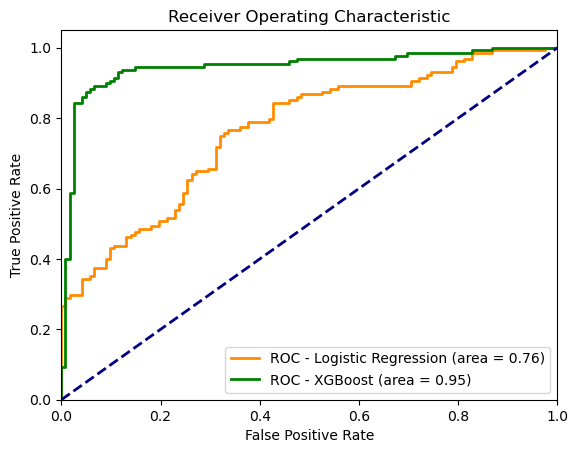

In [23]:
plt.figure()

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC - Logistic Regression (area = %0.2f)' % area)
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC - XGBoost (area = %0.2f)' % area2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# In the chart above, you can see XGBoost is much better model compared to logistic regression

In [24]:
desired_recall = 0.92

closest_index = np.argmin(abs(tpr_xgb - desired_recall))

tpr_xgb[closest_index], thresholds_xgb[closest_index], fpr_xgb[closest_index]

(0.9140625, 0.30599597, 0.10655737704918032)

Threshold associated with 92% recall is 0.3, we will incorporate this in our inference code and deploy the model. Note that with this we will get a false positive rate of around 10% (0.106)